# 3 - Definición de modelos

En este notebook se definen dos arquitecturas de redes neuronales con el objetivo de analizar cual ofrece mejores resultados. En esta etapa inicial no se aplican las técnicas de mejora de *transfer learning*, *data augmentation* o manejo de etiquetas ruidosas. El objetivo es analizar si efectivamente una estructura *CNN+RNN* simple es más robusta que una estructura *CNN* simple.

Por lo tanto, se implementan dos modelos:

1. **Modelo CNN:** captura patrones espaciales entre los voxeles cerebrales en cada instante de tiempo.
2. **Modelo CNN + GRU:** extiende la arquitectura anterior añadiendo una capa recurrente GRU que incorpora información temporal, permitiendo capturar dinámicas en la señal fMRI a lo largo del tiempo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
import time
!pip install codecarbon
from codecarbon import EmissionsTracker

## 3.1 - Creación de conjuntos de entrenamiento y validación.
Este bloque carga los datos ya preparados y realiza la división en conjuntos de entrenamiento y validación de forma estratificada, asegurando que ambos mantengan la misma proporción de clases.

In [ ]:
X = np.load("/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/X_processed.npy")
y = np.load("/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/y_processed.npy")
output_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

In [ ]:
if X.ndim == 4:
    X = X[..., np.newaxis]

X_train_subj, X_temp, y_train_subj, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

X_val_subj, X_test_subj, y_val_subj, y_test_subj = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

In [ ]:
def expand_temporal(X_subj, y_subj):
    """
    Convierte un dataset de secuencias por sujeto en una colección de imágenes individuales por tiempo.

    Esta función aplana la dimensión temporal del dataset, de modo que cada frame temporal se trate
    como una muestra independiente. Las etiquetas se replican para cada frame según el sujeto al que pertenecen.

    Parameters
    ----------
    X_subj : np.ndarray
        Array con forma (N, T, H, W, C), donde N es el número de sujetos y T los pasos temporales.
    y_subj : np.ndarray
        Array con forma (N,) que contiene la etiqueta por sujeto.

    Returns
    -------
    X_flat : np.ndarray
        Array con forma (N*T, H, W, C), una imagen por paso temporal.
    y_flat : np.ndarray
        Array con forma (N*T,) con las etiquetas replicadas por frame.
    """
    X_flat = X_subj.reshape(-1, X_subj.shape[2], X_subj.shape[3], X_subj.shape[4])
    y_flat = np.repeat(y_subj, X_subj.shape[1])
    return X_flat, y_flat

In [ ]:
X_train, y_train = expand_temporal(X_train_subj, y_train_subj)
X_val, y_val = expand_temporal(X_val_subj, y_val_subj)
X_test, y_test = expand_temporal(X_test_subj, y_test_subj)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (4750, 112, 112, 1), Val: (1045, 112, 112, 1), Test: (1045, 112, 112, 1)


In [ ]:
np.save(os.path.join(output_dir, "X_train_notime.npy"), X_train)
np.save(os.path.join(output_dir, "y_train_notime.npy"), y_train)
np.save(os.path.join(output_dir, "X_val_notime.npy"), X_val)
np.save(os.path.join(output_dir, "y_val_notime.npy"), y_val)
np.save(os.path.join(output_dir, "X_test_notime.npy"), X_test)
np.save(os.path.join(output_dir, "y_test_notime.npy"), y_test)

In [ ]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

X_train = np.load(os.path.join(input_dir, "X_train_notime.npy"))
y_train = np.load(os.path.join(input_dir, "y_train_notime.npy"))
X_val = np.load(os.path.join(input_dir, "X_val_notime.npy"))
y_val = np.load(os.path.join(input_dir, "y_val_notime.npy"))
X_test = np.load(os.path.join(input_dir, "X_test_notime.npy"))
y_test = np.load(os.path.join(input_dir, "y_test_notime.npy"))

In [ ]:
def create_dataset(X, y, batch_size=4, shuffle=False, seed=42):
    """
    Crea un objeto `tf.data.Dataset` a partir de arrays de datos y etiquetas.

    Permite definir el tamaño del batch, mezclar los datos (si se desea), y
    optimiza la carga con `prefetch`. Es útil para preparar datos antes de
    entrenar un modelo en TensorFlow.

    Parameters
    ----------
    X : np.ndarray
        Datos de entrada, típicamente con forma (N, ...) donde N es el número de muestras.
    y : np.ndarray
        Etiquetas correspondientes a los datos de entrada.
    batch_size : int, optional
        Número de muestras por batch. Por defecto 4.
    shuffle : bool, optional
        Si es True, mezcla los datos antes de agruparlos. Por defecto False.
    seed : int, optional
        Semilla aleatoria para el `shuffle`. Por defecto 42.

    Returns
    -------
    tf.data.Dataset
        Dataset listo para entrenamiento o evaluación en modelos de TensorFlow.
    """
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=seed)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = create_dataset(X_train, y_train, shuffle=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

## 3.2 - Desarrollo de la red CNN base.
A continuación se lleva a cabo el diseño, compilación, entrenamiento y evaluación de la CNN base.

## 3.2.1 - Diseño.

In [ ]:
@register_keras_serializable()
class CNN_BASE(tf.keras.Model):
    """
    Modelo CNN simple para clasificación binaria de imágenes fMRI 2D.

    Este modelo aplica tres bloques convolucionales con activación ReLU, normalización batch
    y pooling, seguidos de una capa densa y dropout. Está pensado como baseline para tareas
    de clasificación con entrada 2D (e.g. imágenes individuales o cortes).

    Parameters
    ----------
    input_shape : tuple
        Forma de entrada de los datos (H, W, C), sin incluir el batch.
    num_classes : int, optional
        Número de clases de salida. Por defecto 1 (clasificación binaria con sigmoide).

    Returns
    -------
    tf.Tensor
        Tensor de salida con probabilidades por clase. En binaria, forma (batch_size, 1).
    """
    def __init__(self, input_shape, num_classes=1):
        super(CNN_BASE, self).__init__()
        l2 = tf.keras.regularizers.l2(1e-4)

        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=5, padding='same', kernel_regularizer=l2)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.ReLU()
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2)
        self.drop1 = tf.keras.layers.Dropout(0.2)

        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=5, padding='same', kernel_regularizer=l2)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.ReLU()
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=2)

        self.conv3 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_regularizer=l2)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.ReLU()
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.dense1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = tf.keras.layers.Dropout(0.5)

        self.out = tf.keras.layers.Dense(num_classes,
                                         activation='sigmoid' if num_classes == 1 else 'softmax',
                                         kernel_regularizer=l2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training) if training else x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.global_pool(x)

        x = self.dense1(x)
        x = self.dropout(x, training=training) if training else x
        return self.out(x)

### 3.2.2 - Compilación.

In [ ]:
cnn_base_model = CNN_BASE(input_shape=X_train.shape[1:])

cnn_base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


### 3.2.3 - Entrenamiento.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='recall',
    mode='max',
    patience=5,
    restore_best_weights=True
)

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

cnn_base_model_history = cnn_base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 08:44:53] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 08:44:53] [setup] RAM Tracking...
[codecarbon INFO @ 08:44:53] [setup] CPU Tracking...
[codecarbon WARNING @ 08:44:54] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 08:44:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 08:44:54] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 08:44:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 08:44:54] [setup] GPU Tracking...
[codecarbon INFO @ 08:44:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:44:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30
1174/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6800 - auc: 0.5163 - loss: 0.6524 - precision: 0.6984 - recall: 0.9541

[codecarbon INFO @ 08:45:09] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:45:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:45:09] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 08:45:09] Energy consumed for all GPUs : 0.000255 kWh. Total GPU Power : 61.20967731229811 W
[codecarbon INFO @ 08:45:09] 0.000591 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.6803 - auc: 0.5171 - loss: 0.6520 - precision: 0.6985 - recall: 0.9545 - val_accuracy: 0.7273 - val_auc: 0.6798 - val_loss: 0.7407 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7649 - auc: 0.8276 - loss: 0.5173 - precision: 0.7552 - recall: 0.9834 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 1.8472 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9028 - auc: 0.9596 - loss: 0.3162 - precision: 0.8999 - recall: 0.9689 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 1.8172 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/30
 675/1188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9601 - auc: 0.9907 - loss: 0.1821 - precision: 0.9575 - recall: 0.9872

[codecarbon INFO @ 08:45:24] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:45:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:45:24] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 08:45:24] Energy consumed for all GPUs : 0.000518 kWh. Total GPU Power : 63.217721020423554 W
[codecarbon INFO @ 08:45:24] 0.001189 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9611 - auc: 0.9906 - loss: 0.1779 - precision: 0.9588 - recall: 0.9873 - val_accuracy: 0.8182 - val_auc: 0.6885 - val_loss: 0.7003 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9764 - auc: 0.9948 - loss: 0.1244 - precision: 0.9763 - recall: 0.9903 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.1276 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 6/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9651 - auc: 0.9906 - loss: 0.1307 - precision: 0.9643 - recall: 0.9868 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 2.3907 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 7/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9789 - auc: 0.9930 - loss: 0.0990 - precision: 0.9784 - recall: 0.9914 - val_accuracy: 0.7273 - val_auc: 0.6667 - val_loss: 1.8528 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 8/30
 159/1188 ━━━━━━━━━━━━━━

[codecarbon INFO @ 08:45:39] Energy consumed for RAM : 0.000475 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:45:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:45:39] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 08:45:39] Energy consumed for all GPUs : 0.000786 kWh. Total GPU Power : 64.29110371720672 W
[codecarbon INFO @ 08:45:39] 0.001792 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9788 - auc: 0.9941 - loss: 0.0946 - precision: 0.9794 - recall: 0.9907 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 5.1461 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 9/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9853 - auc: 0.9962 - loss: 0.0795 - precision: 0.9835 - recall: 0.9955 - val_accuracy: 0.7273 - val_auc: 0.7136 - val_loss: 1.3844 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 10/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9701 - auc: 0.9913 - loss: 0.1130 - precision: 0.9705 - recall: 0.9868 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.6086 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 11/30
1051/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - auc: 0.9965 - loss: 0.0750 - precision: 0.9842 - recall: 0.9936

[codecarbon INFO @ 08:45:54] Energy consumed for RAM : 0.000633 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:45:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:45:54] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 08:45:54] Energy consumed for all GPUs : 0.001055 kWh. Total GPU Power : 64.57953708734979 W
[codecarbon INFO @ 08:45:54] 0.002397 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9843 - auc: 0.9965 - loss: 0.0751 - precision: 0.9842 - recall: 0.9935 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 7.3684 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 12/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9887 - auc: 0.9984 - loss: 0.0601 - precision: 0.9883 - recall: 0.9958 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 2.9282 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 13/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9754 - auc: 0.9940 - loss: 0.0954 - precision: 0.9764 - recall: 0.9887 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 2.5020 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 14/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9777 - auc: 0.9962 - loss: 0.0864 - precision: 0.9825 - recall: 0.9852 - val_accuracy: 0.6364 - val_auc: 0.4723 - val_loss: 1.6560 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 15/30
 564/1188 ━━━━━━━━━━

[codecarbon INFO @ 08:46:09] Energy consumed for RAM : 0.000791 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:46:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:46:09] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 08:46:09] Energy consumed for all GPUs : 0.001324 kWh. Total GPU Power : 64.41115073387898 W
[codecarbon INFO @ 08:46:09] 0.003000 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9672 - auc: 0.9913 - loss: 0.1097 - precision: 0.9676 - recall: 0.9869 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 5.9358 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 16/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9833 - auc: 0.9972 - loss: 0.0713 - precision: 0.9833 - recall: 0.9933 - val_accuracy: 0.4019 - val_auc: 0.6021 - val_loss: 2.1585 - val_precision: 0.7077 - val_recall: 0.3026
Epoch 17/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9872 - auc: 0.9990 - loss: 0.0571 - precision: 0.9864 - recall: 0.9952 - val_accuracy: 0.7273 - val_auc: 0.5491 - val_loss: 2.2074 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 18/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9892 - auc: 0.9987 - loss: 0.0536 - precision: 0.9915 - recall: 0.9930 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.5966 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 19/30
  90/1188 ━━━━━━━━━━

[codecarbon INFO @ 08:46:24] Energy consumed for RAM : 0.000950 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:46:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:46:24] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 08:46:24] Energy consumed for all GPUs : 0.001594 kWh. Total GPU Power : 64.81294520262358 W
[codecarbon INFO @ 08:46:24] 0.003606 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9905 - auc: 0.9969 - loss: 0.0464 - precision: 0.9909 - recall: 0.9957 - val_accuracy: 0.2823 - val_auc: 0.5618 - val_loss: 2.1437 - val_precision: 0.5250 - val_recall: 0.1382
Epoch 20/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9953 - auc: 0.9998 - loss: 0.0385 - precision: 0.9949 - recall: 0.9981 - val_accuracy: 0.8182 - val_auc: 0.6886 - val_loss: 1.3130 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 21/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9827 - auc: 0.9973 - loss: 0.0626 - precision: 0.9841 - recall: 0.9912 - val_accuracy: 0.7273 - val_auc: 0.5957 - val_loss: 2.2146 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 22/30
 964/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - auc: 0.9988 - loss: 0.0494 - precision: 0.9943 - recall: 0.9937

[codecarbon INFO @ 08:46:39] Energy consumed for RAM : 0.001108 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:46:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:46:39] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 08:46:39] Energy consumed for all GPUs : 0.001863 kWh. Total GPU Power : 64.58624628545701 W
[codecarbon INFO @ 08:46:39] 0.004210 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9911 - auc: 0.9988 - loss: 0.0504 - precision: 0.9937 - recall: 0.9936 - val_accuracy: 0.7273 - val_auc: 0.6218 - val_loss: 2.0168 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 23/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9892 - auc: 0.9987 - loss: 0.0490 - precision: 0.9901 - recall: 0.9947 - val_accuracy: 0.7273 - val_auc: 0.6069 - val_loss: 1.4761 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 24/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9788 - auc: 0.9962 - loss: 0.0848 - precision: 0.9816 - recall: 0.9883 - val_accuracy: 0.6364 - val_auc: 0.6588 - val_loss: 1.1283 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 25/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0341 - precision: 0.9963 - recall: 0.9982 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 2.9436 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 26/30
 484/1188 ━━━━━━━━━━

[codecarbon INFO @ 08:46:54] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:46:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:46:54] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 08:46:54] Energy consumed for all GPUs : 0.002131 kWh. Total GPU Power : 64.41015046469857 W
[codecarbon INFO @ 08:46:54] 0.004814 kWh of electricity used since the beginning.
[codecarbon INFO @ 08:46:54] 0.018883 g.CO2eq/s mean an estimation of 595.5033794091665 kg.CO2eq/year


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9811 - auc: 0.9942 - loss: 0.0855 - precision: 0.9837 - recall: 0.9891 - val_accuracy: 0.3636 - val_auc: 0.6837 - val_loss: 2.6942 - val_precision: 1.0000 - val_recall: 0.1250
Epoch 27/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9964 - auc: 0.9998 - loss: 0.0338 - precision: 0.9963 - recall: 0.9985 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.8442 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 28/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9947 - auc: 0.9998 - loss: 0.0359 - precision: 0.9964 - recall: 0.9960 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.1810 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 29/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9893 - auc: 0.9975 - loss: 0.0535 - precision: 0.9911 - recall: 0.9937 - val_accuracy: 0.7273 - val_auc: 0.5000 - val_loss: 3.8632 - val_precision: 0.7273 - val_recall: 1.0000


[codecarbon INFO @ 08:47:09] Energy consumed for RAM : 0.001425 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:47:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 08:47:09] Energy consumed for All CPU : 0.001593 kWh


Epoch 30/30


[codecarbon INFO @ 08:47:09] Energy consumed for all GPUs : 0.002399 kWh. Total GPU Power : 64.4262875307332 W
[codecarbon INFO @ 08:47:09] 0.005417 kWh of electricity used since the beginning.


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9907 - auc: 0.9951 - loss: 0.0483 - precision: 0.9919 - recall: 0.9946 - val_accuracy: 0.7273 - val_auc: 0.6221 - val_loss: 1.5917 - val_precision: 0.7273 - val_recall: 1.0000


[codecarbon INFO @ 08:47:13] Energy consumed for RAM : 0.001468 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 08:47:13] Delta energy consumed for CPU with constant : 0.000049 kWh, power : 42.5 W
[codecarbon INFO @ 08:47:13] Energy consumed for All CPU : 0.001642 kWh
[codecarbon INFO @ 08:47:13] Energy consumed for all GPUs : 0.002473 kWh. Total GPU Power : 64.6525907133821 W
[codecarbon INFO @ 08:47:13] 0.005583 kWh of electricity used since the beginning.



Tiempo de entrenamiento: 139.12 segundos

Emisiones estimadas: 0.0026 kg de CO2


### 3.2.4 - Evaluación

In [ ]:
def plot_training(history):
    """
    Grafica la evolución de las métricas durante el entrenamiento de un modelo.

    Muestra en cinco subgráficas las curvas de pérdida, exactitud, sensibilidad (recall),
    precisión y AUC tanto en entrenamiento como en validación, en función de las épocas.

    Parameters
    ----------
    history : tf.keras.callbacks.History
        Objeto `History` devuelto por `model.fit()`, que contiene los valores de las métricas por época.

    Returns
    -------
    None
        La función muestra los gráficos en pantalla pero no devuelve ningún valor.
    """
    metric_keys = ['loss', 'accuracy', 'recall', 'precision', 'auc']
    metric_names = ['Pérdida', 'Exactitud', 'Sensibilidad', 'Precisión', 'AUC']

    plt.figure(figsize=(20, 4))

    for i, (key, name) in enumerate(zip(metric_keys, metric_names)):
        plt.subplot(1, 5, i + 1)
        plt.plot(history.history[key], label='Train')
        plt.plot(history.history[f'val_{key}'], label='Val')
        plt.title(name)
        plt.xlabel('Epochs')
        plt.ylabel(name)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def model_metrics(modelo, X_val, y_val, umbral=0.5):
    """
    Evalúa un modelo binario usando arrays NumPy y muestra métricas de clasificación y la matriz de confusión.

    Calcula las métricas más comunes en clasificación binaria: exactitud, precisión, sensibilidad (recall),
    especificidad, F1-score y AUC. También muestra una matriz de confusión con `seaborn`.

    Parameters
    ----------
    modelo : tf.keras.Model
        Modelo ya entrenado que tenga método `.predict()` compatible con `X_val`.
    X_val : np.ndarray
        Datos de entrada a evaluar, normalmente con forma (N, ...).
    y_val : np.ndarray
        Etiquetas reales con forma (N,).
    umbral : float, optional
        Umbral de decisión para convertir probabilidades en clases binarias. Por defecto 0.5.

    Returns
    -------
    None
        Imprime las métricas por consola y muestra una gráfica con la matriz de confusión.
    """
    y_prob = modelo.predict(X_val).flatten()
    y_pred = (y_prob >= umbral).astype(int)

    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    exactitud = (tp + tn) / (tp + tn + fp + fn)
    precision = precision_score(y_val, y_pred)
    sensibilidad = recall_score(y_val, y_pred)
    especificidad = tn / (tn + fp)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print("\nMétricas de evaluación:")
    print(f"{'Exactitud':}: {exactitud:.4f}")
    print(f"{'Precisión':}: {precision:.4f}")
    print(f"{'Sensibilidad':}: {sensibilidad:.4f}")
    print(f"{'Especificidad':}: {especificidad:.4f}")
    print(f"{'Puntuación F1':}: {f1:.4f}")
    print(f"{'Área bajo la curva':}: {auc:.4f}\n")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=["Negativo", "Positivo"],
                yticklabels=["Negativo", "Positivo"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.tight_layout()
    plt.show()

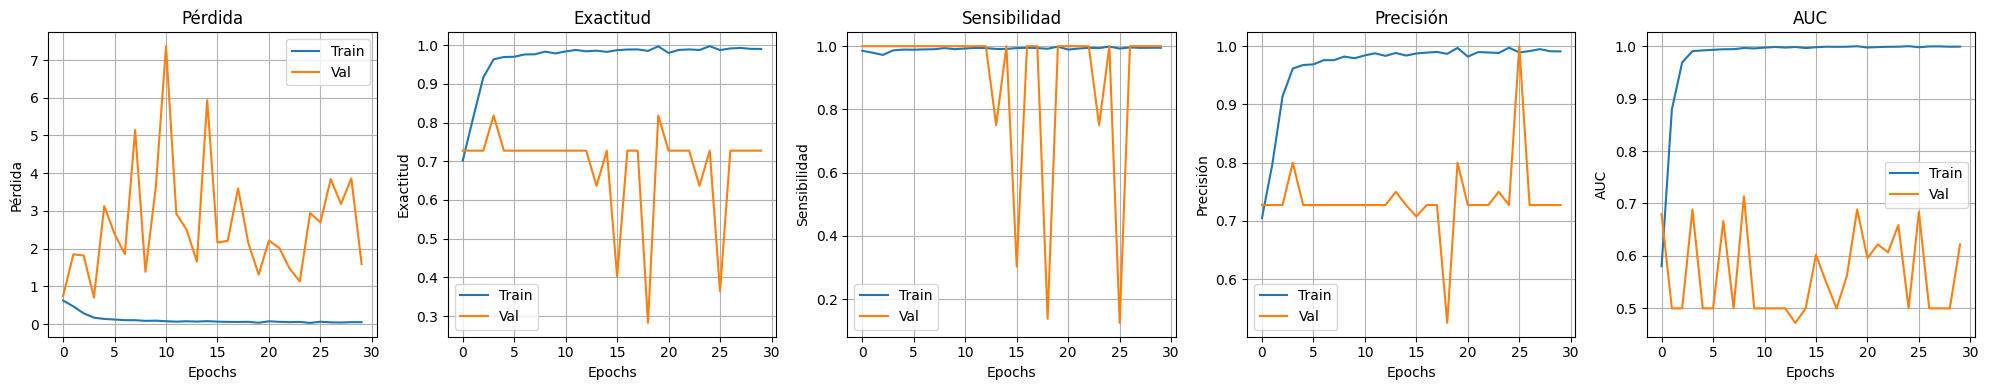

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Métricas de evaluación:
Exactitud: 0.7273
Precisión: 0.7273
Sensibilidad: 1.0000
Especificidad: 0.0000
Puntuación F1: 0.8421
Área bajo la curva: 0.3432



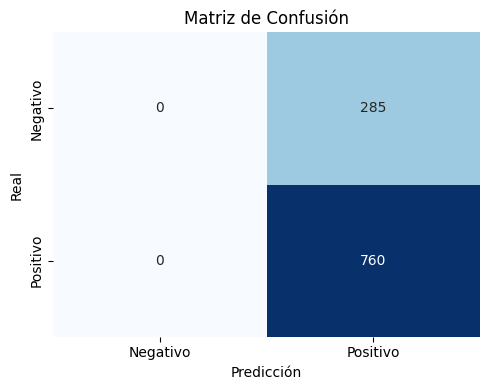

In [ ]:
plot_training(cnn_base_model_history)
model_metrics(cnn_base_model, X_test, y_test)

Los resultados del modelo muestran un claro *overfitting*. El modelo aprende muy bien el entrenamiento pero no generaliza y clasifica casi todos los sujetos como deprimidos, lo que se refleja en un recall alto pero una AUC baja y una precisión estancada.

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

cnn_base_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/CNN_BASE.weights.h5')

with open(os.path.join(models_dir, "CNN_BASE_history.pkl"), "wb") as f:
    pickle.dump(cnn_base_model_history.history, f)

## 3.3 - Desarrollo de la red CNN+RNN simple.

In [ ]:
X = np.load("/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/X_processed.npy")
y = np.load("/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/y_processed.npy")
output_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

In [ ]:
if X.ndim == 4:
    X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

In [ ]:
np.save(os.path.join(output_dir, "X_train_seq.npy"), X_train)
np.save(os.path.join(output_dir, "y_train_seq.npy"), y_train)
np.save(os.path.join(output_dir, "X_val_seq.npy"), X_val)
np.save(os.path.join(output_dir, "y_val_seq.npy"), y_val)
np.save(os.path.join(output_dir, "X_test_seq.npy"), X_test)
np.save(os.path.join(output_dir, "y_test_seq.npy"), y_test)

In [ ]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/splits/"

X_train = np.load(os.path.join(input_dir, "X_train_seq.npy"))
y_train = np.load(os.path.join(input_dir, "y_train_seq.npy"))
X_val = np.load(os.path.join(input_dir, "X_val_seq.npy"))
y_val = np.load(os.path.join(input_dir, "y_val_seq.npy"))
X_test = np.load(os.path.join(input_dir, "X_test_seq.npy"))
y_test = np.load(os.path.join(input_dir, "y_test_seq.npy"))

In [ ]:
train_ds = create_dataset(X_train, y_train, batch_size=2, shuffle=True)
val_ds = create_dataset(X_val, y_val, batch_size=2)
test_ds = create_dataset(X_test, y_test, batch_size=2)

### 3.3.1 - Diseño.

In [ ]:
@register_keras_serializable()
class CNN_GRU_BASE(tf.keras.Model):
    """
    Modelo CNN-GRU básico para clasificación binaria de secuencias de imágenes fMRI 2D.

    La arquitectura aplica convoluciones espaciales independientes por cada paso temporal
    usando `TimeDistributed`, seguidas de una capa GRU que modela la dependencia temporal.
    Finaliza con una capa densa y salida sigmoide para clasificación binaria.

    Parameters
    ----------
    input_shape : tuple
        Forma de entrada sin el batch, típicamente (T, H, W, C), donde T son pasos temporales.
    num_classes : int, optional
        Número de clases de salida. Por defecto 1 (clasificación binaria).

    Returns
    -------
    tf.Tensor
        Tensor de salida con probabilidades por clase. En binaria, forma (batch_size, 1).
    """
    def __init__(self, input_shape, num_classes=1):
        super(CNN_GRU_BASE, self).__init__()
        l2 = tf.keras.regularizers.l2(1e-4)

        self.conv1 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(32, kernel_size=5, padding='same', kernel_regularizer=l2)
        )
        self.bn1 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act1 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.pool1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.drop1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2))

        self.conv2 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(64, kernel_size=5, padding='same', kernel_regularizer=l2)
        )
        self.bn2 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act2 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.pool2 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2))

        self.conv3 = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_regularizer=l2)
        )
        self.bn3 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.act3 = tf.keras.layers.TimeDistributed(tf.keras.layers.ReLU())
        self.global_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())

        self.gru = tf.keras.layers.GRU(64, return_sequences=False)

        self.dense1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.out = tf.keras.layers.Dense(num_classes,
                                         activation='sigmoid' if num_classes == 1 else 'softmax',
                                         kernel_regularizer=l2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training) if training else x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.global_pool(x)

        x = self.gru(x)

        x = self.dense1(x)
        x = self.dropout(x, training=training) if training else x
        return self.out(x)

### 3.3.2 - Compilación.

In [ ]:
cnn_gru_base_model = CNN_GRU_BASE(input_shape=X_train.shape[1:])

cnn_gru_base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

### 3.3.3 - Entrenamiento.

In [ ]:
tracker = EmissionsTracker()
tracker.start()
start = time.time()

cnn_gru_base_model_history = cnn_gru_base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

end = time.time()
emissions = tracker.stop()
print(f"\nTiempo de entrenamiento: {(end - start):.2f} segundos")
print(f"\nEmisiones estimadas: {emissions:.4f} kg de CO2")

[codecarbon WARNING @ 09:55:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:55:22] [setup] RAM Tracking...
[codecarbon INFO @ 09:55:22] [setup] CPU Tracking...
[codecarbon WARNING @ 09:55:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:55:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:55:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 09:55:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:55:23] [setup] GPU Tracking...
[codecarbon INFO @ 09:55:23] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:55:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Epoch 1/30


[codecarbon INFO @ 09:55:39] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:55:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:55:39] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 09:55:39] Energy consumed for all GPUs : 0.000234 kWh. Total GPU Power : 56.02328120637764 W
[codecarbon INFO @ 09:55:39] 0.000569 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:55:54] Energy consumed for RAM : 0.000316 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:55:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:55:54] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 09:55:54] Energy consumed for all GPUs : 0.000470 kWh. Total GPU Power : 56.68190678724446 W
[codecarbon INFO @ 09:55:54] 0.001140 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:56:09] Energy consumed for RAM : 0.000475 kWh. RAM Power : 3

 8/25 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.9358 - auc: 0.9335 - loss: 0.5630 - precision: 0.9896 - recall: 0.9335

[codecarbon INFO @ 09:57:24] Energy consumed for RAM : 0.001266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:57:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:57:24] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 09:57:24] Energy consumed for all GPUs : 0.001996 kWh. Total GPU Power : 81.22543016479902 W
[codecarbon INFO @ 09:57:24] 0.004678 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:57:24] 0.018349 g.CO2eq/s mean an estimation of 578.6611758425047 kg.CO2eq/year


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7323 - auc: 0.7063 - loss: 0.6298 - precision: 0.7877 - recall: 0.8683

[codecarbon INFO @ 09:57:39] Energy consumed for RAM : 0.001424 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:57:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:57:39] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 09:57:39] Energy consumed for all GPUs : 0.002463 kWh. Total GPU Power : 112.0429870664557 W
[codecarbon INFO @ 09:57:39] 0.005480 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7303 - auc: 0.7033 - loss: 0.6302 - precision: 0.7852 - recall: 0.8690 - val_accuracy: 0.7273 - val_auc: 0.3542 - val_loss: 0.6339 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/30
16/25 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.7233 - auc: 0.3366 - loss: 0.6243 - precision: 0.7815 - recall: 0.9083

[codecarbon INFO @ 09:57:54] Energy consumed for RAM : 0.001582 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:57:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:57:54] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 09:57:54] Energy consumed for all GPUs : 0.002919 kWh. Total GPU Power : 109.59447523292981 W
[codecarbon INFO @ 09:57:54] 0.006271 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.7231 - auc: 0.3816 - loss: 0.6284 - precision: 0.7657 - recall: 0.9313 - val_accuracy: 0.7273 - val_auc: 0.4792 - val_loss: 0.6187 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6330 - auc: 0.2698 - loss: 0.7341 - precision: 0.6330 - recall: 1.0000

[codecarbon INFO @ 09:58:09] Energy consumed for RAM : 0.001740 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:58:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:58:09] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 09:58:09] Energy consumed for all GPUs : 0.003573 kWh. Total GPU Power : 156.94160198101844 W
[codecarbon INFO @ 09:58:09] 0.007260 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.6411 - auc: 0.2755 - loss: 0.7268 - precision: 0.6411 - recall: 1.0000 - val_accuracy: 0.7273 - val_auc: 0.5208 - val_loss: 0.6176 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.6142 - auc: 0.5405 - loss: 0.6922 - precision: 0.6142 - recall: 1.0000 - val_accuracy: 0.7273 - val_auc: 0.2917 - val_loss: 0.6154 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 5/30
 4/25 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.2708 - auc: 0.4089 - loss: 0.9068 - precision: 0.2708 - recall: 0.7500 

[codecarbon INFO @ 09:58:24] Energy consumed for RAM : 0.001899 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:58:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:58:24] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 09:58:24] Energy consumed for all GPUs : 0.004227 kWh. Total GPU Power : 157.118949551546 W
[codecarbon INFO @ 09:58:24] 0.008250 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - accuracy: 0.6071 - auc: 0.5105 - loss: 0.6901 - precision: 0.6071 - recall: 0.9615 - val_accuracy: 0.7273 - val_auc: 0.3750 - val_loss: 0.6117 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 6/30
10/25 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - accuracy: 0.6904 - auc: 0.5109 - loss: 0.6652 - precision: 0.6904 - recall: 1.0000

[codecarbon INFO @ 09:58:39] Energy consumed for RAM : 0.002057 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:58:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:58:39] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 09:58:39] Energy consumed for all GPUs : 0.004884 kWh. Total GPU Power : 157.65611791436427 W
[codecarbon INFO @ 09:58:39] 0.009242 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.6770 - auc: 0.4333 - loss: 0.6801 - precision: 0.6770 - recall: 1.0000 - val_accuracy: 0.7273 - val_auc: 0.5833 - val_loss: 0.6098 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 7/30
16/25 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.6671 - auc: 0.8211 - loss: 0.6086 - precision: 0.6589 - recall: 1.0000

[codecarbon INFO @ 09:58:54] Energy consumed for RAM : 0.002215 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:58:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:58:54] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 09:58:54] Energy consumed for all GPUs : 0.005542 kWh. Total GPU Power : 157.98732846582885 W
[codecarbon INFO @ 09:58:54] 0.010236 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.6881 - auc: 0.8035 - loss: 0.5967 - precision: 0.6804 - recall: 1.0000 - val_accuracy: 0.7273 - val_auc: 0.5417 - val_loss: 0.6094 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 8/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7318 - auc: 0.5444 - loss: 0.6097 - precision: 0.7346 - recall: 0.9942

[codecarbon INFO @ 09:59:09] Energy consumed for RAM : 0.002374 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:59:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 09:59:09] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 09:59:09] Energy consumed for all GPUs : 0.006200 kWh. Total GPU Power : 157.95974277450367 W
[codecarbon INFO @ 09:59:09] 0.011229 kWh of electricity used since the beginning.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.7253 - auc: 0.5423 - loss: 0.6133 - precision: 0.7294 - recall: 0.9915 - val_accuracy: 0.7273 - val_auc: 0.5417 - val_loss: 0.6081 - val_precision: 0.7273 - val_recall: 1.0000


[codecarbon INFO @ 09:59:10] Energy consumed for RAM : 0.002384 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 09:59:10] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 09:59:10] Energy consumed for All CPU : 0.002667 kWh
[codecarbon INFO @ 09:59:10] Energy consumed for all GPUs : 0.006247 kWh. Total GPU Power : 166.58613564904266 W
[codecarbon INFO @ 09:59:10] 0.011299 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:59:10] 0.029400 g.CO2eq/s mean an estimation of 927.1662214456309 kg.CO2eq/year



Tiempo de entrenamiento: 226.03 segundos

Emisiones estimadas: 0.0053 kg de CO2


### 3.3.4 - Evaluación.

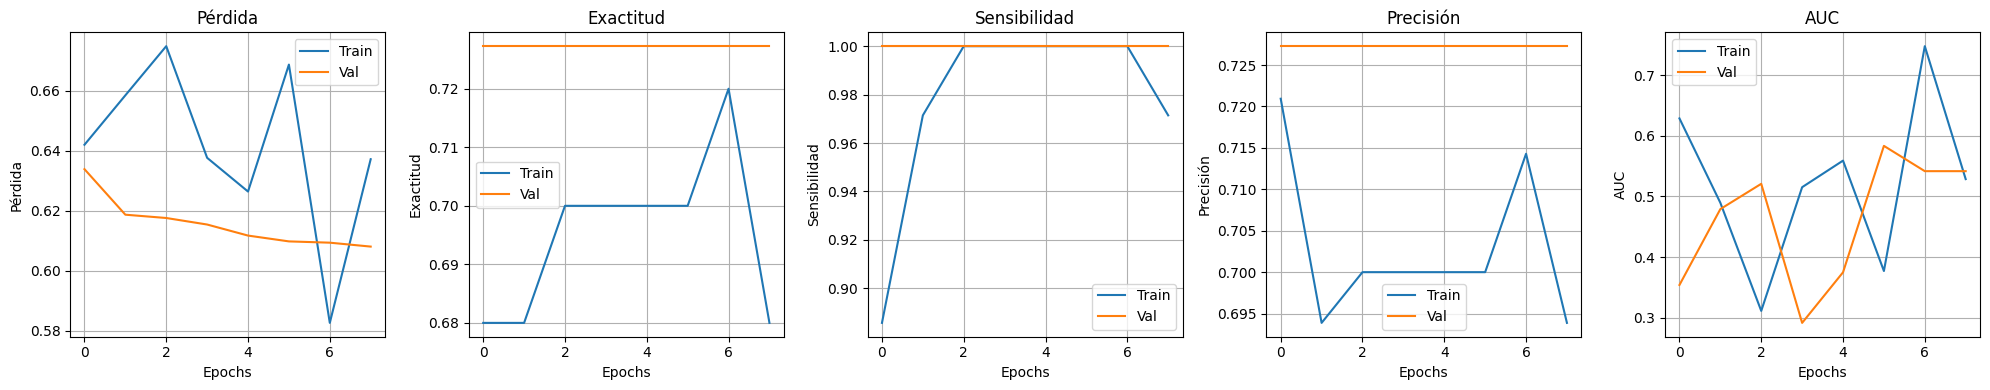

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

Métricas de evaluación:
Exactitud: 0.7273
Precisión: 0.7273
Sensibilidad: 1.0000
Especificidad: 0.0000
Puntuación F1: 0.8421
Área bajo la curva: 0.4167



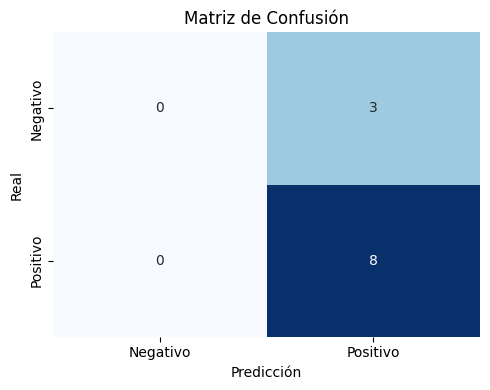

In [ ]:
plot_training(cnn_gru_base_model_history)
model_metrics(cnn_gru_base_model, X_test, y_test)

A pesar de incorporar la dimensión temporal, al igual que el modelo anterior, los resultados también muestran un claro overfitting. El modelo aprende muy bien el entrenamiento pero no generaliza y clasifica casi todos los sujetos como deprimidos.

In [ ]:
models_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models"

cnn_gru_base_model.save_weights('/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/models/CNN_GRU_BASE.weights.h5')

with open(os.path.join(models_dir, "CNN_GRU_BASE_history.pkl"), "wb") as f:
    pickle.dump(cnn_gru_base_model_history.history, f)

## Conclusión.
Este análisis pone de manifiesto que, en estudios con muestras reducidas, es indispenzable la aplicación de estrategias para mejorar el rendimiento de los modelos (*data augmentation, transfer learning*). Ambos modelos son incapaces de generalizar y clasifican todos los datos como pertenecientes a la clase positiva (depresión). Esto se debe a que el conjunto de datos está desbalanceado. Según estos datos no se puede concluir que el modelo CNN+RNN sea una mejor opción. En el siguiente notebook se evaluará el impacto de técnicas como *transfer learning*, *data augmentation* y manejo de *noisy labels*, con el objetivo de desarrollar modelos más robustos y precisos.